# Super Resolution Project

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

from scipy import ndimage
from six.moves import cPickle as pickle

%matplotlib inline

# Autoreload modules
%load_ext autoreload
%autoreload 2

## SRCNN
This is a very simple CNN for super resolution.

http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html

In [2]:
checkpoint_dir = 'checkpoints/srcnn/'
scale = 3
stride = 14

In [20]:
def randomize_dataset(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [.299, .587, .114])

def preprocess(dataset_dir, checkpoint_dir, image_size=33, label_size=21, scale=scale, stride=stride, is_train=True):
        
        sub_input_sequence = []
        sub_label_sequence = []
        padding = abs(image_size - label_size)
        pixel_depth = 255.0

        for filename in os.listdir(dataset_dir):
            
            path = os.path.join(dataset_dir, filename)
            #image = (plt.imread(path, flatten=True, mode='YCbCr').astype(np.float) - pixel_depth/2)/pixel_depth
            image = plt.imread(path)
            #image = rgb2gray(image)
            #image = (plt.imread(path).astype(np.float) - pixel_depth/2)/pixel_depth
            #if is_grayscale:
            #else:
            #    image = (ndimage.imread(path, mode='YCbCr').astype(np.float) - pixel_depth/2)/pixel_depth

            if len(image.shape) == 3:
                h, w, _ = image.shape
                h = h - np.mod(h, scale)
                w = w - np.mod(w, scale)
                image = image[0:h, 0:w, :]
            else:
                h, w = image.shape
                h = h - np.mod(h, scale)
                w = w - np.mod(w, scale)
                image = image[0:h, 0:w]
            
           
            label_ = image
            input_ = np.asarray([ndimage.zoom(label_[:,:,c], (1./3), prefilter=False) for c in range(label_.shape[2])])
            input_ = np.asarray([ndimage.zoom(input_[c, :,:], (3), prefilter=False) for c in range(label_.shape[2])])
            input_ = np.moveaxis(input_, 0, -1)

            for x in range(0, h-image_size+1, stride):
                for y in range(0, w-image_size+1, stride):
                    sub_input = input_[x:x+image_size, y:y+image_size, :] # [33 x 33]
                    sub_label = label_[x+int(padding):x+int(padding)+label_size,
                                       y+int(padding):y+int(padding)+label_size, :] # [21 x 21]

                    # Make channel value
                    #sub_input = sub_input.reshape([image_size, image_size, 1])  
                    #sub_label = sub_label.reshape([label_size, label_size, 1])
                    
                    sub_input_sequence.append(sub_input)
                    sub_label_sequence.append(sub_label)

        arrdata = np.asarray(sub_input_sequence) # [?, 33, 33, 1]
        arrlabel = np.asarray(sub_label_sequence) # [?, 21, 21, 1]
        
        if is_train:
            savepath = os.path.join(checkpoint_dir, 'train.pickle')
            data, labels = randomize_dataset(arrdata, arrlabel)
        else:
            savepath = os.path.join(checkpoint_dir, 'validate.pickle')
            data, labels = (arrdata, arrlabel)
        
        with open(savepath, 'wb') as f:
            pickle.dump({'data': data,
                         'labels': labels}, f, pickle.HIGHEST_PROTOCOL)
            f.close()
        
        return data, labels

X_train, Y_train = preprocess(dataset_dir='datasets/DIV2K/DIV2K_train_HR', checkpoint_dir=checkpoint_dir)
X_val, Y_val = preprocess(dataset_dir='datasets/DIV2K/DIV2K_valid_LR', checkpoint_dir=checkpoint_dir, is_train=False)


In [3]:
def load_data(checkpoint_dir, is_train=True):
    if is_train:
        path = os.path.join(checkpoint_dir, 'train.pickle')
    else:
        path = os.path.join(checkpoint_dir, 'validate.pickle')

    with open(path, 'rb') as f:
        dataset = pickle.load(f)
        input_ = dataset['data']
        label_ = dataset['labels']

    return input_, label_


X_train, Y_train = load_data(checkpoint_dir)
X_val, Y_val = load_data(checkpoint_dir, is_train=False)
    

Epoch: 12, step: 2000, loss: 38.17238845
Epoch: 23, step: 4000, loss: 36.24772653
Epoch: 34, step: 6000, loss: 34.20752706
Epoch: 45, step: 8000, loss: 31.35434585
Epoch: 56, step: 10000, loss: 37.83750813
Epoch: 67, step: 12000, loss: 32.26661822
Epoch: 78, step: 14000, loss: 27.62681805
Epoch: 89, step: 16000, loss: 33.98888744
Epoch: 100, step: 18000, loss: 31.46683332


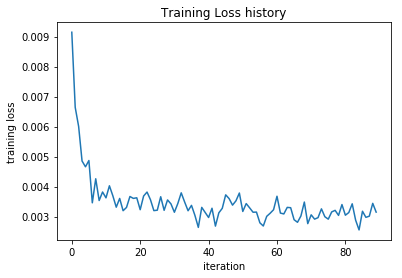

In [27]:
from models.srcnn import SRCNN

with tf.Session() as sess:

    srcnn = SRCNN(sess, learning_rate=1e-4, num_epoches=100, batch_size=256, stddev=1e-1, channels=3,
                  checkpoint_dir=checkpoint_dir, sample_dir='samples/srcnn')

    #srcnn.load_checkpoint(None)
    loss_hist = srcnn.train(X_train, Y_train, verbose=True)
    Y_hat_val, weights = srcnn.predict(X_val)
    #layer1 = srcnn.predict(X_val)

plt.plot(loss_hist)
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()


### Result detail compare

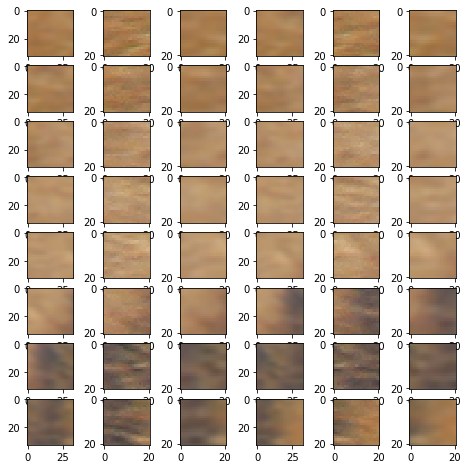

In [28]:

Y_hat = np.asarray(Y_hat_val)
Y_hat = Y_hat.reshape(16704,21,21,3)

fig = plt.figure(figsize=(8,8))

x_offset, y_offset = (2,2)
for i in range(16):
    
    plt.subplot(8,6,i*3+1)
    plt.imshow(X_val[i])
    plt.subplot(8,6,i*3+2)
    plt.imshow(Y_val[i])
    plt.subplot(8,6,i*3+3)
    plt.imshow(Y_hat[i])


### Show predict

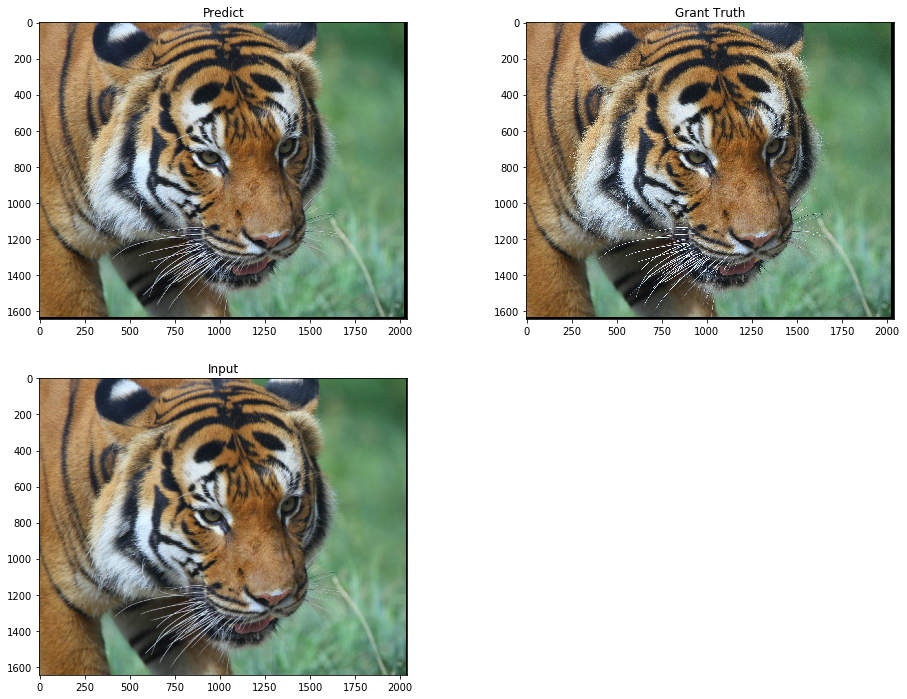

In [29]:
import cv2
def merge_image(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((size[0], size[1], 3))
    num_cols = 1+(size[1]-33+1)//stride
    for idx, image in enumerate(images):
        i = idx % num_cols
        j = idx // num_cols
        img[j*stride:j*stride+h, i*stride:i*stride+w, :] = image

    return img

merged_y_hat = merge_image(Y_hat, [1644, 2040])
merged_y_hat[merged_y_hat>=1]=0.999
merged_y_hat[merged_y_hat<0]=0

merged_y_val = merge_image(Y_val, [1644, 2040])
merged_x_val = merge_image(X_val, [1644, 2040])

fig = plt.figure(figsize=(16,12))
plt.subplot(221)
plt.title('Predict')
plt.imshow(merged_y_hat)
plt.subplot(222)
plt.title('Grant Truth')
plt.imshow(merged_y_val)
plt.subplot(223)
plt.title('Input')
plt.imshow(merged_x_val)


### Show weights image

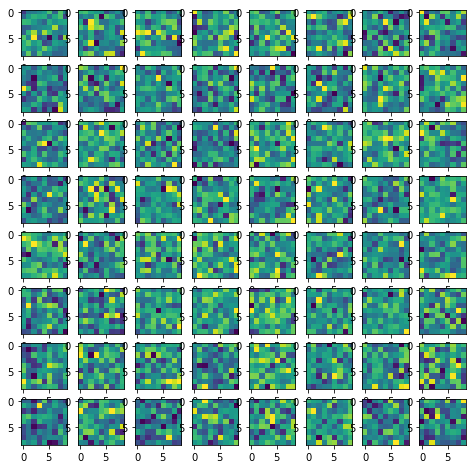

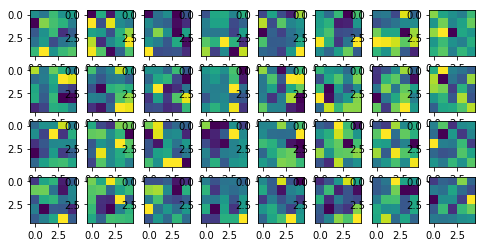

In [25]:

w1 = weights['w1']
w2 = weights['w2']
w3 = weights['w3']

plt.figure(figsize=(8,8))

for i in range(64):
    
    w_img = (w1[:,:,:,i]-np.min(w1[:,:,:,i]))/np.max(w1[:,:,:,i])
    #print(w_img)
    w_img = rgb2gray(w_img)
    plt.subplot(8,8,i+1)
    plt.imshow(w_img)

plt.figure(figsize=(8,8))

for i in range(32):
    
    w_img = (w3[:,:,i,:]-np.min(w3[:,:,i,:]))/np.max(w3[:,:,i,:])
    w_img = rgb2gray(w_img)
    plt.subplot(8,8,i+1)
    plt.imshow(w_img)

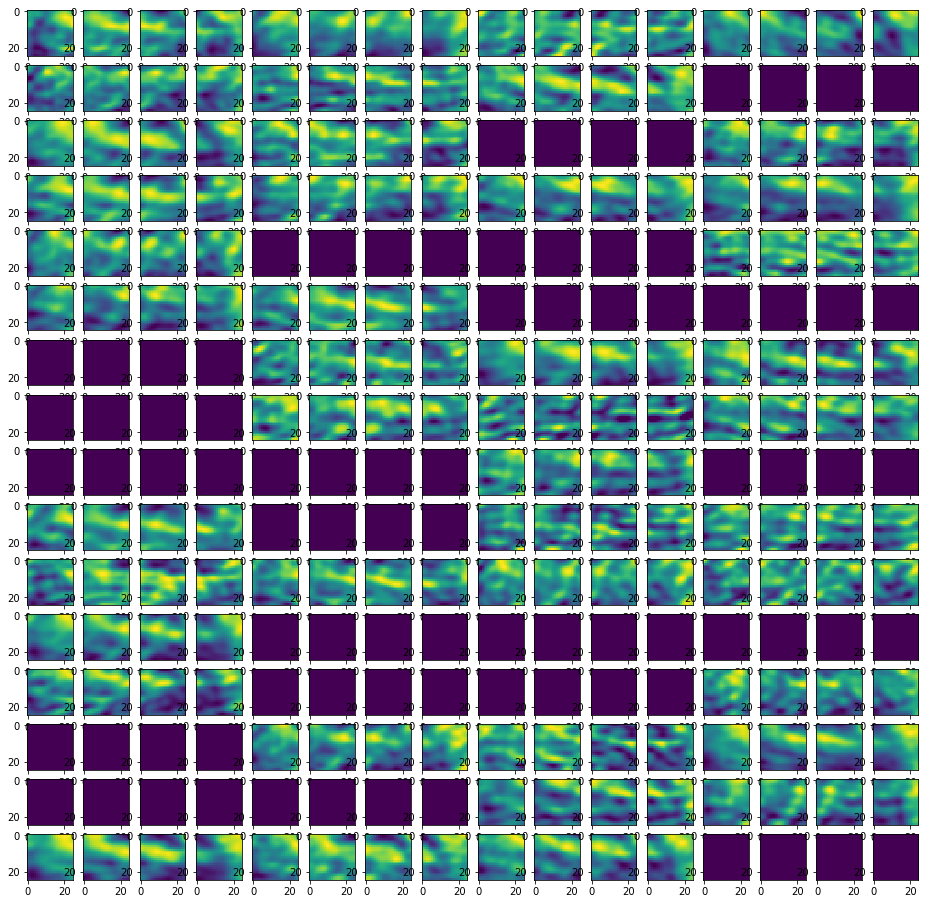

In [26]:
img_layer1 = np.asarray(layer1).reshape(16704,25,25,64)

plt.figure(figsize=(16,16))

for i in range(64):
    
    img = img_layer1[0,:,:,i]
    plt.subplot(16,16,i*4+1)
    plt.imshow(img)
    
    img = img_layer1[1,:,:,i]
    plt.subplot(16,16,i*4+2)
    plt.imshow(img)
    
    img = img_layer1[2,:,:,i]
    plt.subplot(16,16,i*4+3)
    plt.imshow(img)
    
    img = img_layer1[3,:,:,i]
    plt.subplot(16,16,i*4+4)
    plt.imshow(img)